This example demonstrates how to use the `transformer` algorithm to calculate the boost factor for a 20 disk configuration.

### Julia Init

In [2]:
#Parallelization
using Distributed

In [3]:
# If you installed BoostFractor
@everywhere begin
    using BoostFractor
end

┌ Info: Precompiling BoostFractor [222d2961-0b53-58be-99ce-9613a82efb32]
└ @ Base loading.jl:1260


In [2]:
# If you just downloaded the githup repository and do not want to install the package
@everywhere begin
    push!(LOAD_PATH, "../src");
    using BoostFractor;
end

In [8]:
#Plotting
using PyPlot

### Initialize Transformer

In [6]:
@everywhere begin
    
    # Coordinate System
    dx = 0.02
    coords = SeedCoordinateSystem(X = -0.5:dx:0.5, Y = -0.5:dx:0.5)
    
    diskR = 0.15
    
    # SetupBoundaries (note that this expects the mirror to be defined explicitly as a region)
    epsilon = 24
    eps = Array{Complex{Float64}}([NaN, 1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1])
    distance = [0.0, 1.00334, 1.0,
                            6.94754, 1.0,
                            7.1766, 1.0,
                            7.22788, 1.0,
                            7.19717, 1.0,
                            7.23776, 1.0,
                            7.07746, 1.0,
                            7.57173, 1.0,
                            7.08019, 1.0,
                            7.24657, 1.0,
                            7.21708, 1.0,
                            7.18317, 1.0,
                            7.13025, 1.0,
                            7.2198, 1.0,
                            7.45585, 1.0,
                            7.39873, 1.0,
                            7.15403, 1.0,
                            7.14252, 1.0,
                            6.83105, 1.0,
                            7.42282, 1.0,
                            0.0]*1e-3
    
    sbdry = SeedSetupBoundaries(coords, diskno=20, distance=distance, epsilon=eps)
    
    
    # Initialize modes
    
    Mmax = 4
    Lmax = 3
    modes = SeedModes(coords, ThreeDim=true, Mmax=Mmax, Lmax=Lmax, diskR=diskR)
    
    #  Mode-Vector defining beam shape to be reflected on the system
    m_reflect = zeros(Mmax*(2*Lmax+1))
    m_reflect[Lmax+1] = 1.0
end

### Run Transformer

In [7]:
df = 0.01*1e9
frequencies = 21.98e9:df:22.26e9

# We will build a 3-dim array [reflection / boost factor, mode-vector, frequency ]
# The following function appends to the last dimension
@everywhere zcat(args...) = cat(dims = 3, args...)

# Sweep over frequency
@time EoutModes0 = @sync @distributed (zcat) for f in frequencies    
    println("Frequency: $f")
    boost, refl = transformer(sbdry,coords,modes; reflect=m_reflect, prop=propagator,diskR=0.15,f=f)
    transpose([boost  refl])
end;

121.110057 seconds (41.30 M allocations: 83.973 GiB, 17.10% gc time)


### Plot the result

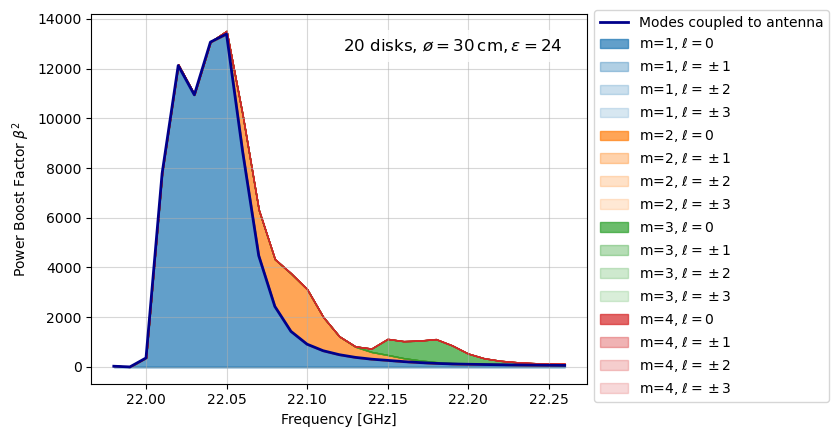

In [10]:
# Plot the power contained in each mode in a "stacked areas" plot

# Total power of modes iterated over / plotted so far
tot = zeros(length(EoutModes0[1,1,:]))
# Iterate over modes
for i in 1:(modes.M*(modes.L*2+1))
    # get (m,l) indices
    m = Int( floor((i-1)/(modes.L*2+1))+1 )
    l = (i-1)%(modes.L*2+1)-modes.L
    # create label
    labeling = (l > 0 ? "m=$m, \$\\ell=\\pm\$$l" : l == 0 ? "m=$m, \$\\ell=0\$" : nothing)
    
    # do the plotting
    fill_between(frequencies/1e9,tot, tot.+abs2.(EoutModes0[1,i,:]), alpha=0.7/(1+abs(l)), label=labeling, color="C$(m-1)")
    
    # update total power
    tot .+= abs2.(EoutModes0[1,i,:])
end

# Coupling to antenna beam
coupled_power = abs2.(sum(conj.(EoutModes0[1,:,:]).*m_reflect, dims=1)[1,:])
plot(frequencies/1e9, coupled_power, c="darkblue", linewidth=2, label="Modes coupled to antenna")

# Legend, Labels, etc.
legend(loc="upper left", bbox_to_anchor=(1, 1.03))
xlabel("Frequency [GHz]")
ylabel("Power Boost Factor \$\\beta^2\$")
grid(alpha=0.5)
textstring="20 disks, \$\\o = 30\\,{\\rm cm}, \\epsilon = 24\$"
text(0.95, 0.9, textstring, ha="right", fontsize=12, transform=gca().transAxes, bbox=Dict("facecolor" => "white", "alpha" => 0.8, "pad" => 5, "linewidth" => 0));
